In [2]:
from perfetto.trace_processor import TraceProcessor, TraceProcessorConfig
import matplotlib.pyplot as plt


In [349]:
# 创建 TraceProcessorConfig 对象并设置 verbose=True
config = TraceProcessorConfig(verbose=True,bin_path='./trace_processor')

# 初始化 TraceProcessor 对象时传入配置对象
tp = TraceProcessor(trace='./pixel/trace-mindar-three-2-4096',config=config)
qr_it = tp.query('select ts, counter_track.name, value  from counter left join counter_track where counter_track.id=counter.track_id')
qr_df = qr_it.as_pandas_dataframe()
print(qr_df.head())

[671.271]             httpd.cc:99 [HTTP] Starting RPC server on localhost:58817
[671.271]            httpd.cc:104 [HTTP] This server can be used by reloading https://ui.perfetto.dev and clicking on YES on the "Trace Processor native acceleration" dialog or through the Python API (see https://perfetto.dev/docs/analysis/trace-processor#python-api).


                 ts               name           value
0  2169156335365580    batt.charge_uah       4562000.0
1  2169156335365580  batt.capacity_pct           100.0
2  2169156335365580    batt.current_ua         -7812.0
3  2169156337000000    power.rails.tpu    7539869430.0
4  2169156337000000  power.rails.modem  156857393025.0


[672.223]       http_server.cc:83 [HTTP] New connection
[672.223]      http_server.cc:231 [HTTP] GET /status [body=0B, origin=""]
[672.223]       http_server.cc:90 [HTTP] Client disconnected
[672.226]       http_server.cc:83 [HTTP] New connection
[672.226]      http_server.cc:231 [HTTP] POST /parse [body=105366B, origin=""]
[672.230]      http_server.cc:231 [HTTP] GET /notify_eof [body=0B, origin=""]
Loading trace 0.11 MB (0.0 MB/s)
[672.239]      http_server.cc:231 [HTTP] POST /query [body=116B, origin=""]


In [350]:
power_df = qr_df[qr_df['name'].str[:5] == 'power']
print(power_df['ts'].value_counts())

ts
2169156337000000    16
2169156339000000    16
2169197394000000     8
2169197149000000     8
2169197147000000     8
                    ..
2169175646000000     8
2169175645000000     8
2169175396000000     8
2169175394000000     8
2169216145000000     8
Name: count, Length: 480, dtype: int64


['power.rails.aoc.logic', 'power.rails.aoc.memory', 'power.rails.cpu.big', 'power.rails.cpu.little', 'power.rails.cpu.mid', 'power.rails.ddr.a', 'power.rails.ddr.b', 'power.rails.ddr.c', 'power.rails.display', 'power.rails.gpu', 'power.rails.memory.interface', 'power.rails.modem', 'power.rails.radio.frontend', 'power.rails.system.fabric', 'power.rails.tpu', 'power.rails.wifi.bt']


/var/folders/xk/5bd8h9y930n1m1vlv1v2r_wc0000gn/T/ipykernel_33812/3057949353.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_diffs_nonzero = time_diffs.replace(0, float('nan'))
/var/folders/xk/5bd8h9y930n1m1vlv1v2r_wc0000gn/T/ipykernel_33812/3057949353.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ratio'] =  diffs / time_diffs_nonzero*1000
/var/folders/xk/5bd8h9y930n1m1vlv1v2r_wc0000gn/T/ipykernel_33812/3057949353.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be re

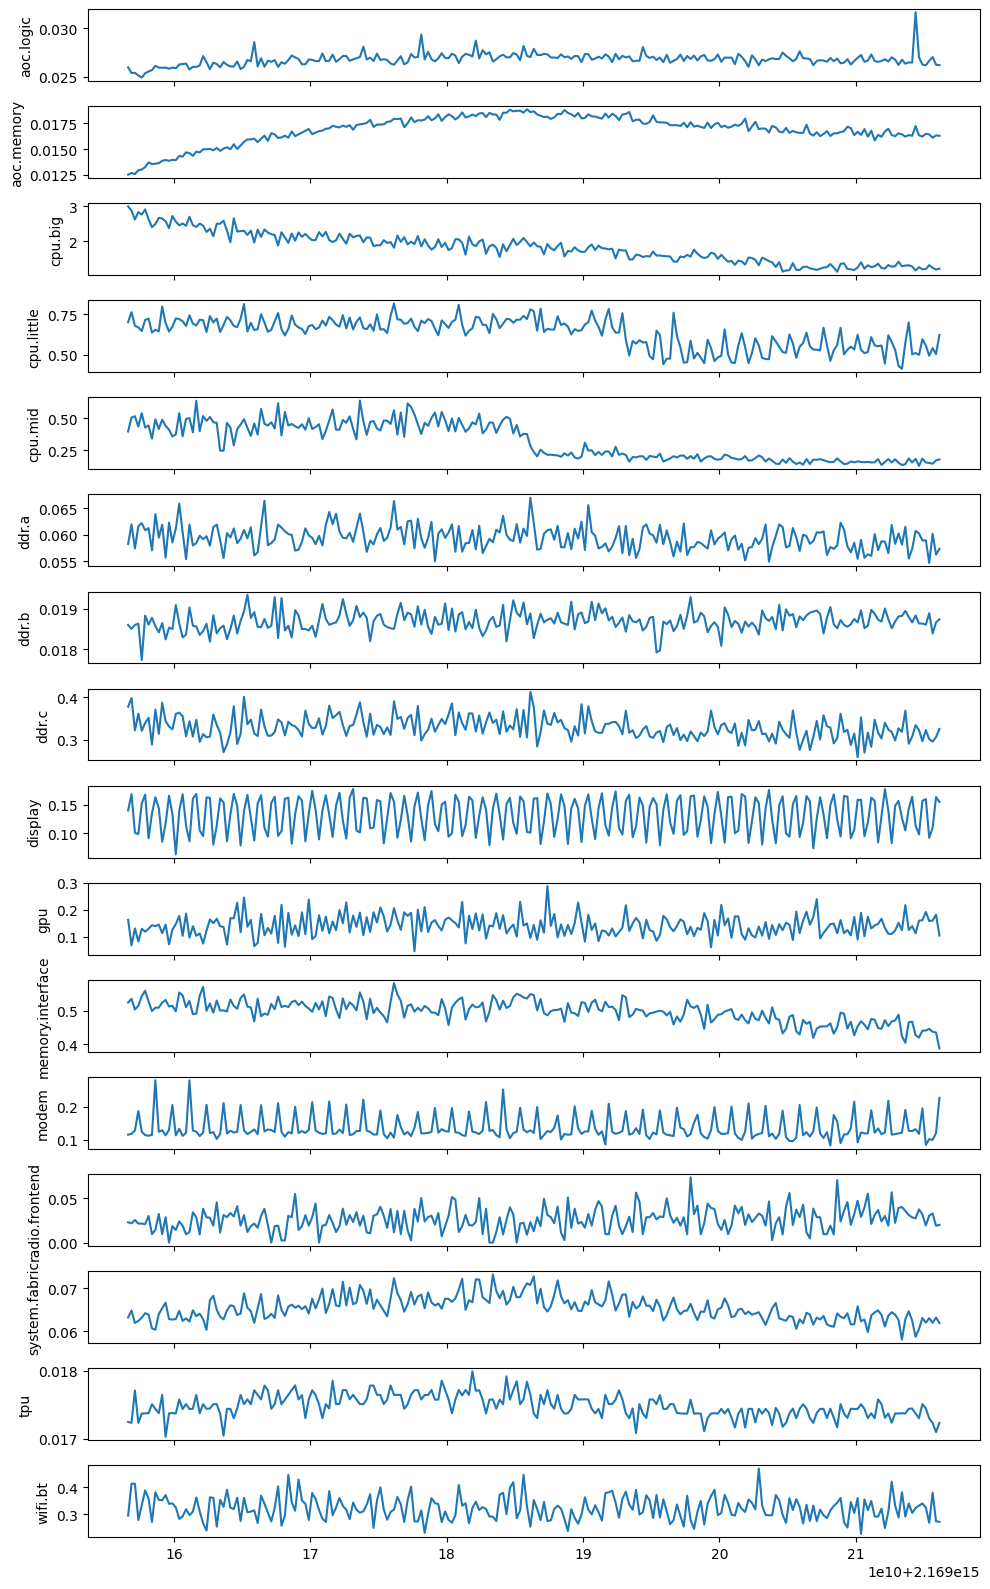

In [351]:

# 获取所有唯一的 'name'
unique_names = sorted(power_df['name'].unique())
print(unique_names)

# 确定子图的行数和列数
num_rows = len(unique_names)
num_cols = 1

# 创建一个新的图形，包含所需行列的子图
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 1*num_rows), sharex=True)

# 遍历每个 'name'，在相应的子图中绘制对应的数据
for i, name in enumerate(unique_names):
    # 选择当前 'name' 对应的数据
    data = power_df[power_df['name'] == name]
    diffs = data['value'].diff()
    time_diffs = data['ts'].diff()
    time_diffs_nonzero = time_diffs.replace(0, float('nan'))
    data['ratio'] =  diffs / time_diffs_nonzero*1000
    # data['ratio'] = 
   
    # 绘制线图
    # axes[i].plot(data['ts'].iloc[1:], diffs.iloc[1:], label=name)
    data_cleaned = data.dropna(subset=['ratio'])
    axes[i].plot(data_cleaned['ts'], data_cleaned['ratio'],label=name)
   
    # 添加标题和标签
    axes[i].set_ylabel(name[12:])



# 调整子图布局
plt.tight_layout()

# 显示图形
plt.show()


In [352]:
total_mean_ratio = 0
name_mean_ratio = {}
for i, name in enumerate(unique_names):
    # 选择当前 'name' 对应的数据
    data = power_df[power_df['name'] == name]
    diffs = data['value'].diff()
    time_diffs = data['ts'].diff()
    time_diffs_nonzero = time_diffs.replace(0, float('nan'))
    data['ratio'] =  diffs / time_diffs_nonzero*1000
    data_cleaned = data.dropna(subset=['ratio'])
    # 计算 data_cleaned 的平均值
    mean_ratio = data_cleaned['ratio'].mean()
    # 打印结果
    name_mean_ratio[name] = mean_ratio
    total_mean_ratio += mean_ratio

print("sum:", total_mean_ratio)
for name, mean_ratio in name_mean_ratio.items():
    ratio_percentage = (mean_ratio / total_mean_ratio) * 100
    print(f"{name} :{mean_ratio}, {ratio_percentage:.2f}%")


sum: 4.558036738559825
power.rails.aoc.logic :0.026787490838683273, 0.59%
power.rails.aoc.memory :0.016882627467100078, 0.37%
power.rails.cpu.big :1.8142191571165671, 39.80%
power.rails.cpu.little :0.6346694114170665, 13.92%
power.rails.cpu.mid :0.3185963442308297, 6.99%
power.rails.ddr.a :0.05946983914438828, 1.30%
power.rails.ddr.b :0.018686187700176903, 0.41%
power.rails.ddr.c :0.32936289677463143, 7.23%
power.rails.display :0.13184584804721827, 2.89%
power.rails.gpu :0.1423205311073626, 3.12%
power.rails.memory.interface :0.49778193195882325, 10.92%
power.rails.modem :0.13592785442062602, 2.98%
power.rails.radio.frontend :0.02604868014419445, 0.57%
power.rails.system.fabric :0.06539729338740954, 1.43%
power.rails.tpu :0.017486821473395767, 0.38%
power.rails.wifi.bt :0.322553823331352, 7.08%


/var/folders/xk/5bd8h9y930n1m1vlv1v2r_wc0000gn/T/ipykernel_33812/1654585340.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_diffs_nonzero = time_diffs.replace(0, float('nan'))
/var/folders/xk/5bd8h9y930n1m1vlv1v2r_wc0000gn/T/ipykernel_33812/1654585340.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ratio'] =  diffs / time_diffs_nonzero*1000
/var/folders/xk/5bd8h9y930n1m1vlv1v2r_wc0000gn/T/ipykernel_33812/1654585340.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be remov